In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pathlib
from os.path import isfile
from matplotlib import pyplot as plt
from PIL import Image as pil_image
from tqdm import tqdm_notebook
import pickle
import numpy as np
from imagehash import phash
from math import sqrt
from collections import namedtuple
from collections import defaultdict
from operator import itemgetter
import glob
import csv
import json
import random
import pandas as pd
from pandas.core.frame import DataFrame
import queue
import threading
import time

In [2]:
class DatasetInfo():
    """This class is for showing some useful infomation about the dataset, such as the absolute path of the dataset, the folder hierarchy of
        the dataset, the duplicate images in the dataset (optional), image numbers of each category (with or without consideration of 
        duplicate images).
    """
    def __init__(self, remove_duplicate_image=True, show_duplicate_image=True):
        self._dataset_path = pathlib.Path.cwd()
        self.remove_duplicate_image = remove_duplicate_image
        self.show_duplicate_image = show_duplicate_image
        self._duplicate_ignored_list = []   
        self.pattern = ('.jpg', '.jpeg', '.png', '.tif', '.bmp', '.ppm')
        self.folder_hierarchy = {} # {diseaseA: {/***/supplier1, /***/supplier2}, diseaseB:{/***/supplier3, /***/supplier2}}
        
    @property
    def absolute_dataset_path(self):
        return self._dataset_path
        
    @absolute_dataset_path.setter
    def absolute_dataset_path(self, relative_dataset_path=""):
        if pathlib.Path(relative_dataset_path).exists():
            self._dataset_path = pathlib.Path.cwd() / relative_dataset_path
            
    def _get_hierarchy(self, path, folder_set):
        """This is a sub-function of instance method folder_hierarchy_dict().
        """
        for child in path.iterdir():
            if child.is_dir():
                self._get_hierarchy(child, folder_set)
            else:
                if child.name.lower().endswith(self.pattern):
                    folder_set.add(str(child.parent))
        return folder_set
    
    @property
    def folder_hierarchy_dict(self):
        """This is a property depicting the folder hierarchy of the dataset, such as 
        {diseaseA: {/***/supplier1, /***/supplier2}, diseaseB:{/***/supplier3, /***/supplier2}}
        """
        if not self.folder_hierarchy:
            for child in pathlib.Path(self._dataset_path).iterdir():  # disease A, disease B, disease C, etc. of species X 
                folder_set = set()
                folder_set = self._get_hierarchy(child, folder_set)
                if folder_set:
                    self.folder_hierarchy[str(child).split('/')[-1]] = folder_set
        return self.folder_hierarchy
    
    def _match(self, h1, h2, h2ps, folder_name):
        """This is a sub-function of private instance method _calculate_duplicate().
        """
        for p1 in h2ps[folder_name][h1]:
            for p2 in h2ps[folder_name][h2]:
                i1 =  pil_image.open(folder_name + '/' + p1)
                i2 =  pil_image.open(folder_name + '/' + p2)
                if i1.mode != i2.mode or i1.size != i2.size: return False
                a1 = np.array(i1)
                a1 = a1 - a1.mean()
                a1 = a1/sqrt((a1**2).mean())
                a2 = np.array(i2)
                a2 = a2 - a2.mean()
                a2 = a2/sqrt((a2**2).mean())
                a  = ((a1 - a2)**2).mean()
                if a > 0.1: return False
        return True
    
    def _calculate_duplicate(self, path):
        """This is a sub-function of private instance method _get_all_duplicate().
        This private instance method will calculate all of the paired p-hash values of images under the same folder, and pick out the image
        to be kept among the duplicate images.
        """
        image_path = [ip for ip in path.iterdir() if ip.name.lower().endswith(self.pattern)]
        p2size = {}
        p2h = {}
        h2ps = {}
        h2h = {}
        duplicate_list_each_folder = []
        imgs = []
        imgs_name = []
        imgs_len = []
        folder_name = str(image_path[0].parent)
        p2size[folder_name] = {}
        
        for ip in image_path:
            size = pil_image.open(str(ip)).size
            p2size[folder_name][ip.name] = size
        
        if isfile(str(pathlib.Path.cwd()) + "/temp/" + folder_name.split('/')[-1] + "_p2h.pickle"):
            with open(str(pathlib.Path.cwd()) + "/temp/" + folder_name.split('/')[-1] + "_p2h.pickle", 'rb') as f:
                p2h[folder_name] = pickle.load(f)
        else:      
            p2h[folder_name] = {}   # Compute phash for each image under the same folder.
            for ip in image_path:
                img = pil_image.open(str(ip))
                h = phash(img)
                p2h[folder_name][ip.name] = h
            
            # Find all images associated with a given phash value.
            h2ps[folder_name] = {}
            for p,h in p2h[folder_name].items():
                if h not in h2ps[folder_name]: h2ps[folder_name][h] = []
                if p not in h2ps[folder_name][h]: h2ps[folder_name][h].append(p)
            # Find all distinct phash values
            hs = list(h2ps[folder_name].keys())

            # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
            h2h[folder_name] = {}
            for i,h1 in enumerate(tqdm_notebook(hs, desc=folder_name.split('/')[-1])):
                for h2 in hs[:i]:
                    if h1-h2 <= 6 and self._match(h1, h2, h2ps, folder_name):
                        s1 = str(h1)
                        s2 = str(h2)
                        if s1 < s2: 
                            s1,s2 = s2,s1
                        h2h[folder_name][s1] = s2
            # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
            for p,h in p2h[folder_name].items():
                h = str(h)
                if h in h2h[folder_name]: 
                    h = h2h[folder_name][h]
                p2h[folder_name][p] = h
            
            with open(str(pathlib.Path.cwd()) + "/temp/" + folder_name.split('/')[-1] + "_p2h.pickle", 'wb') as f:
                pickle.dump(p2h[folder_name], f)
            
        h2ps[folder_name] = {}
        for p,h in p2h[folder_name].items():
            if h not in h2ps[folder_name]: h2ps[folder_name][h] = []
            if p not in h2ps[folder_name][h]: h2ps[folder_name][h].append(p)
        
        for h, ps in h2ps[folder_name].items():
            if len(ps) >= 2:
                imgs.append([pil_image.open(folder_name + '/' + p) for p in ps])
                imgs_name.append([folder_name.split('/')[-1] + '/' + p for p in ps])
                imgs_len.append(len(ps))
                best_p = ps[0]
                best_s = p2size[folder_name][best_p]
                for i in range(1, len(ps)):
                    p = ps[i]
                    s = p2size[folder_name][p]
                    if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
                        best_p = p
                        best_s = s
                DuplicateInfo = namedtuple("DuplicateInfo", ["parent_path", "duplicate_image", "kept_image"])
                duplicate_list_each_folder.append(DuplicateInfo(folder_name, ps, best_p))
        return (duplicate_list_each_folder, imgs, imgs_name, imgs_len)
    
    def _show_duplicates(self, imgs, imgs_name, per_row=2):
        """This is a sub-function of private instance method _get_all_duplicate().
        """
        n = len(imgs)
        rows = (n + per_row - 1)//per_row
        cols = min(per_row, n)
        fig, axes = plt.subplots(rows, cols, figsize=(24//per_row*cols,24//per_row*rows))
        for i, ax in enumerate(axes.flatten()): 
            ax.axis('off')
            ax.set_title(imgs_name[i], fontsize=15)
        for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))
    
    def _get_all_duplicate(self):
        """This private instance method will return a named tuple list, each column is correasonding to the parent of the duplicate image path, 
        the duplicate images' names and the only image to be kept in the dataset. Meanwhile, if duplicate images is under oconsideration, you
        can also choose to show or not show the duplicate images.
        """
        duplicate_list = []
        if self.folder_hierarchy:
            for disease_name in self.folder_hierarchy:
                subfolder_list = list(self.folder_hierarchy[disease_name])
                for folder in subfolder_list:
                    temp_list, imgs, imgs_name, imgs_len = self._calculate_duplicate(pathlib.Path(folder))
                    duplicate_list.extend(temp_list)
                    if self.show_duplicate_image:
                        for i in range(len(imgs_len)):
                            self._show_duplicates(imgs[i], imgs_name[i], per_row=imgs_len[i])
        return duplicate_list
    
    @property
    def duplicate_be_ignored(self):
        """This is a property, if consider duplicate images, it will return a list of absolute path of duplicated images to be ignored.
        """
        if self.remove_duplicate_image:
            temp_duplicate = self._get_all_duplicate()
            self._duplicate_ignored_list.extend([[item.parent_path + "/" + p for p in item.duplicate_image if p != item.kept_image][0]
                                                 for item in temp_duplicate])
        else:
            self._duplicate_ignored_list = []
        return self._duplicate_ignored_list
    
    def get_dataset_statistics(self):
        """This instance method will count the image numbers of each category with or without consideration of duplicate images.
        """
        category_image_number_list = []
        image_relative_path_list = []
        for disease_name in self.folder_hierarchy:
            subfolder_list = list(self.folder_hierarchy[disease_name])
            img_num = 0
            for folder in subfolder_list:
                if self.remove_duplicate_image:
                    img_num += len(list({str(image) for image in pathlib.Path(folder).iterdir()} - 
                                        {image for image in self._duplicate_ignored_list}))
                    image_relative_path_list.extend([str(pathlib.Path(item).relative_to(self._dataset_path))
                                                     for item in list({str(image) for image in pathlib.Path(folder).iterdir()} - 
                                        {image for image in self._duplicate_ignored_list})])
                else:
                    img_num += len([str(image) for image in pathlib.Path(folder).iterdir()])
                    image_relative_path_list.extend([str(pathlib.Path(item).relative_to(self._dataset_path))
                                                     for item in [str(image) for image in pathlib.Path(folder).iterdir()]])
            category_image_number_list.append((disease_name, img_num))
            category_image_number_list.sort(key=itemgetter(0))
        return (category_image_number_list, image_relative_path_list)
                                                
dataset = DatasetInfo(remove_duplicate_image=True, show_duplicate_image=True)
print("The absolute dataset path is:")
dataset.absolute_dataset_path = "raw_datasets/images/plantVillage/" # species X
print(dataset.absolute_dataset_path)

The absolute dataset path is:
/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage


In [3]:
print(dataset.folder_hierarchy_dict)

{'Raspberry___healthy': {'/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Raspberry___healthy'}, 'Corn_(maize)___Northern_Leaf_Blight': {'/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Corn_(maize)___Northern_Leaf_Blight'}, 'Cherry_(including_sour)___healthy': {'/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Cherry_(including_sour)___healthy'}, 'Apple___Cedar_apple_rust': {'/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Apple___Cedar_apple_rust'}, 'Potato___healthy': {'/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Potato___healthy'}, 'Potato___Early_blight': {'/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Potato___Early_blight'}, 'Tomato___Target_Spot': {'/home/gxty/pycharmProjects/plant_disease_detection_project/raw_da

The duplicate images to be ignored:
['/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Orange___Haunglongbing_(Citrus_greening)/UF.Citrus_HLB_Lab 1216.JPG', '/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Orange___Haunglongbing_(Citrus_greening)/UF.Citrus_HLB_Lab 1136.JPG', '/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Orange___Haunglongbing_(Citrus_greening)/UF.Citrus_HLB_Lab 0095.JPG', '/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Orange___Haunglongbing_(Citrus_greening)/UF.Citrus_HLB_Lab 9992.JPG', '/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Orange___Haunglongbing_(Citrus_greening)/UF.Citrus_HLB_Lab 9852.JPG', '/home/gxty/pycharmProjects/plant_disease_detection_project/raw_datasets/images/plantVillage/Orange___Haunglongbing_(Citrus_greening)/UF.Citrus_HLB_

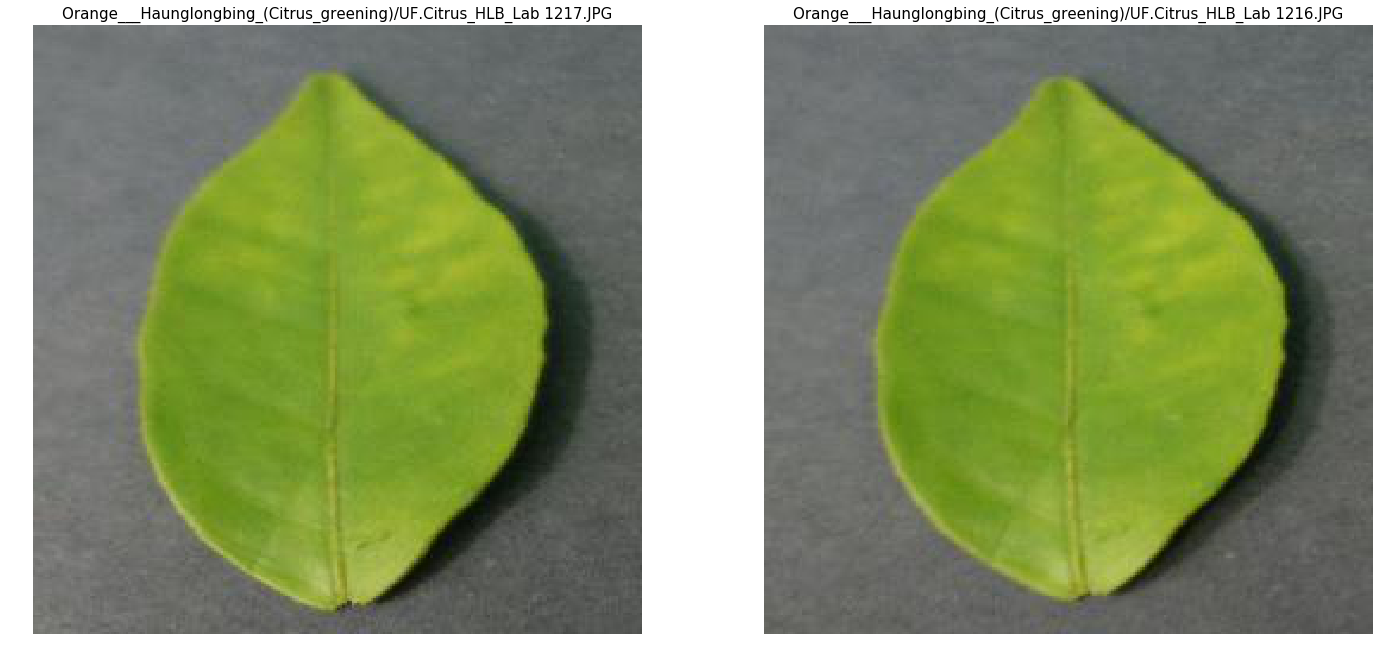

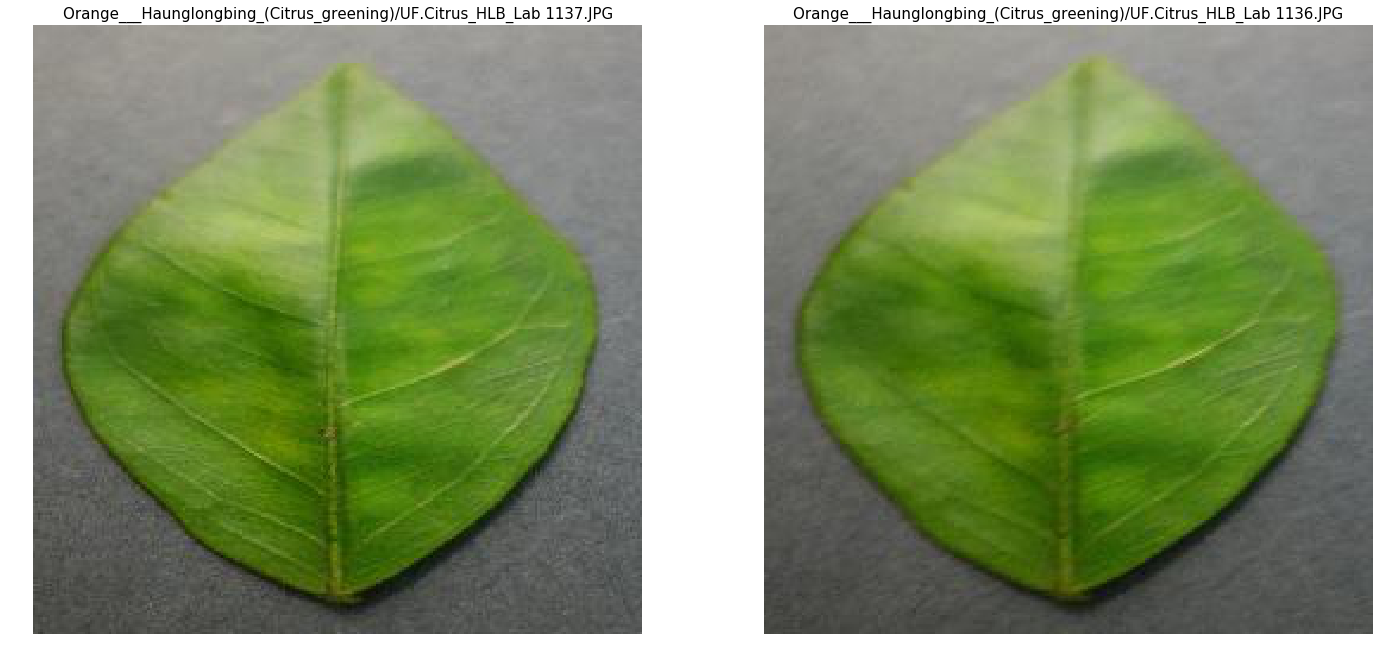

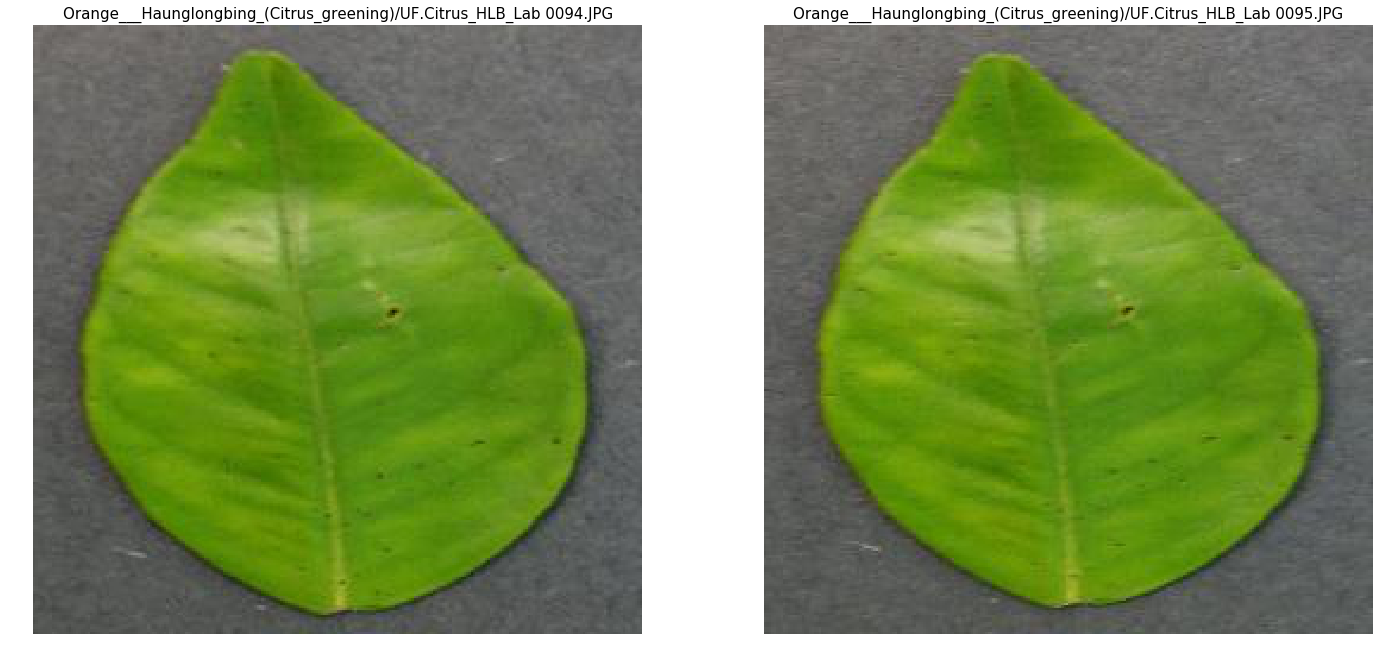

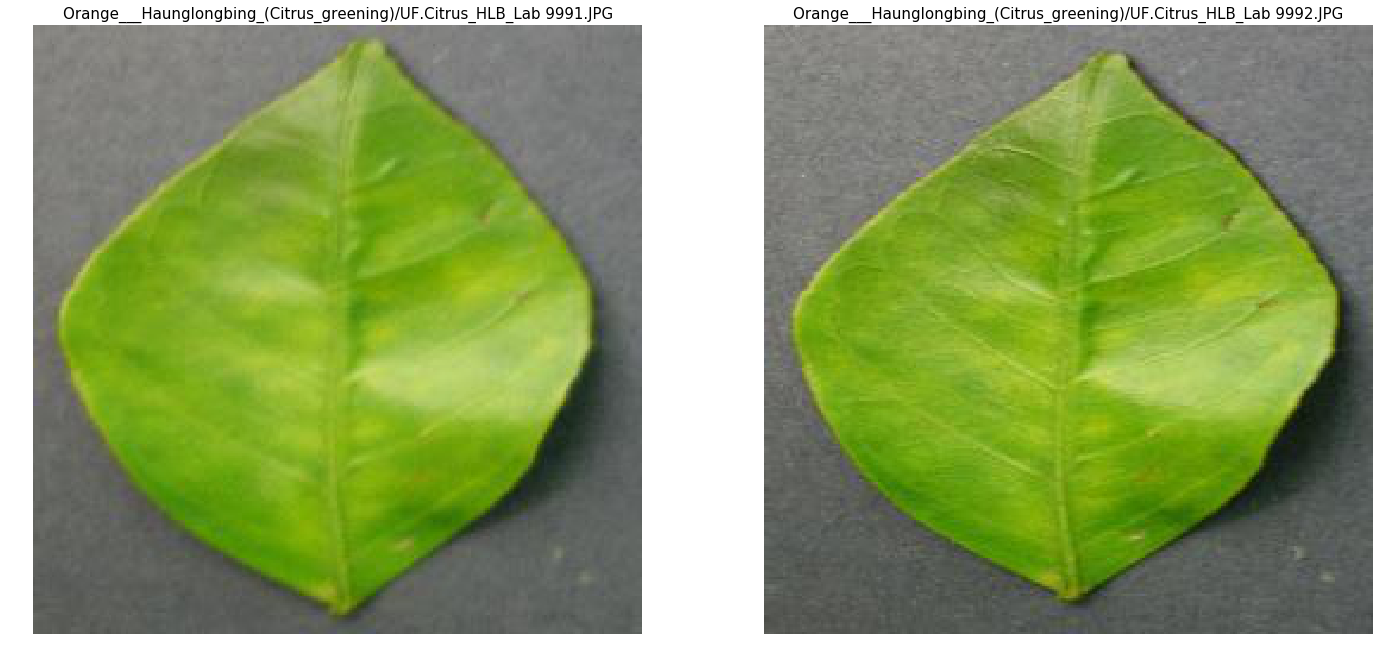

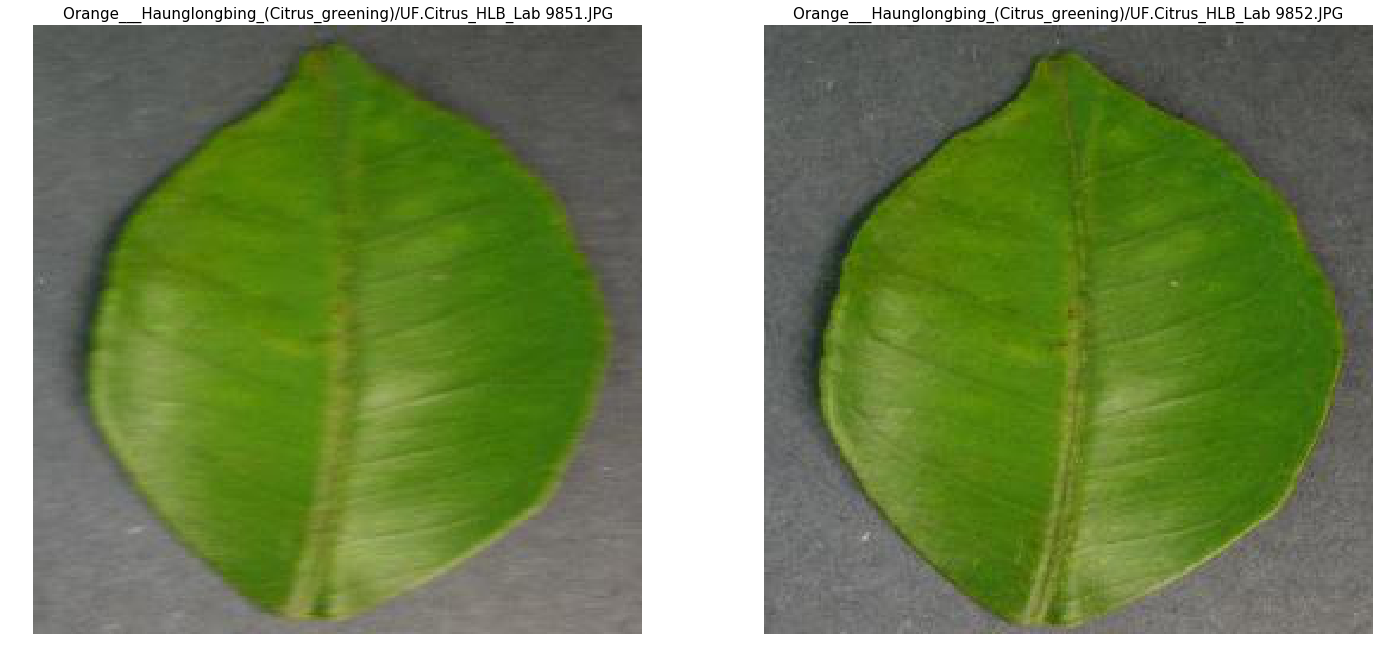

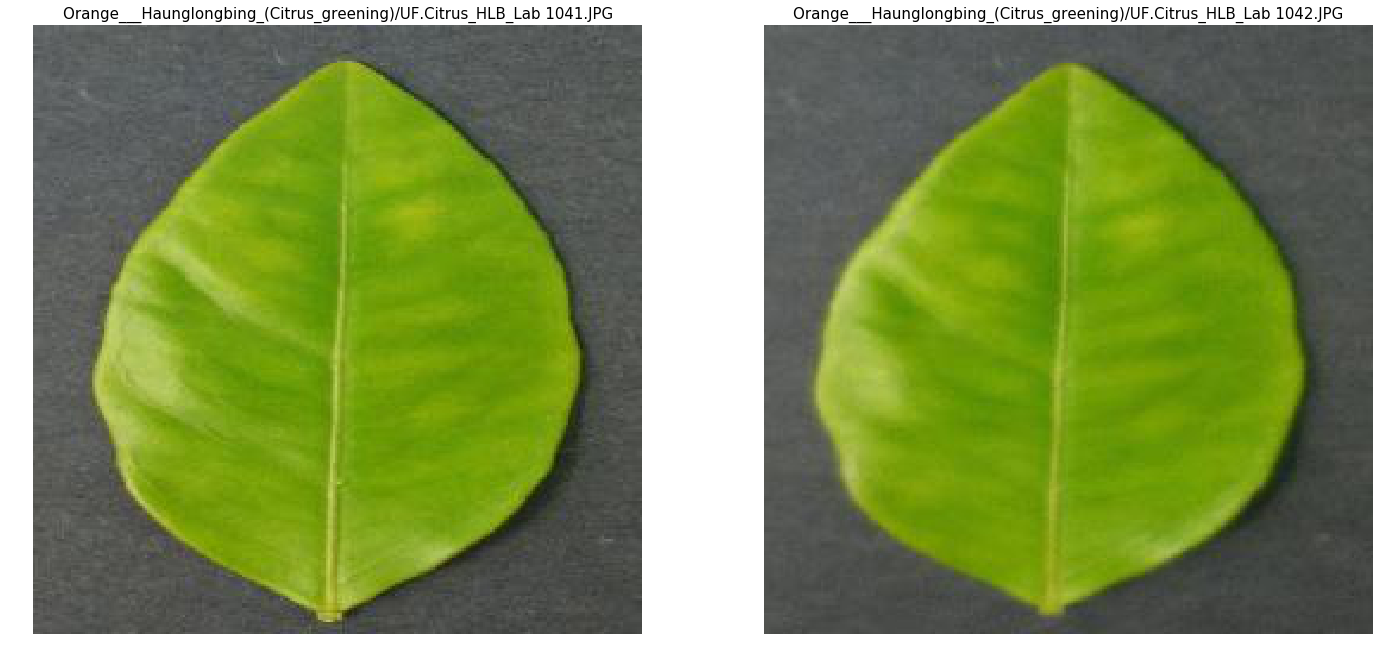

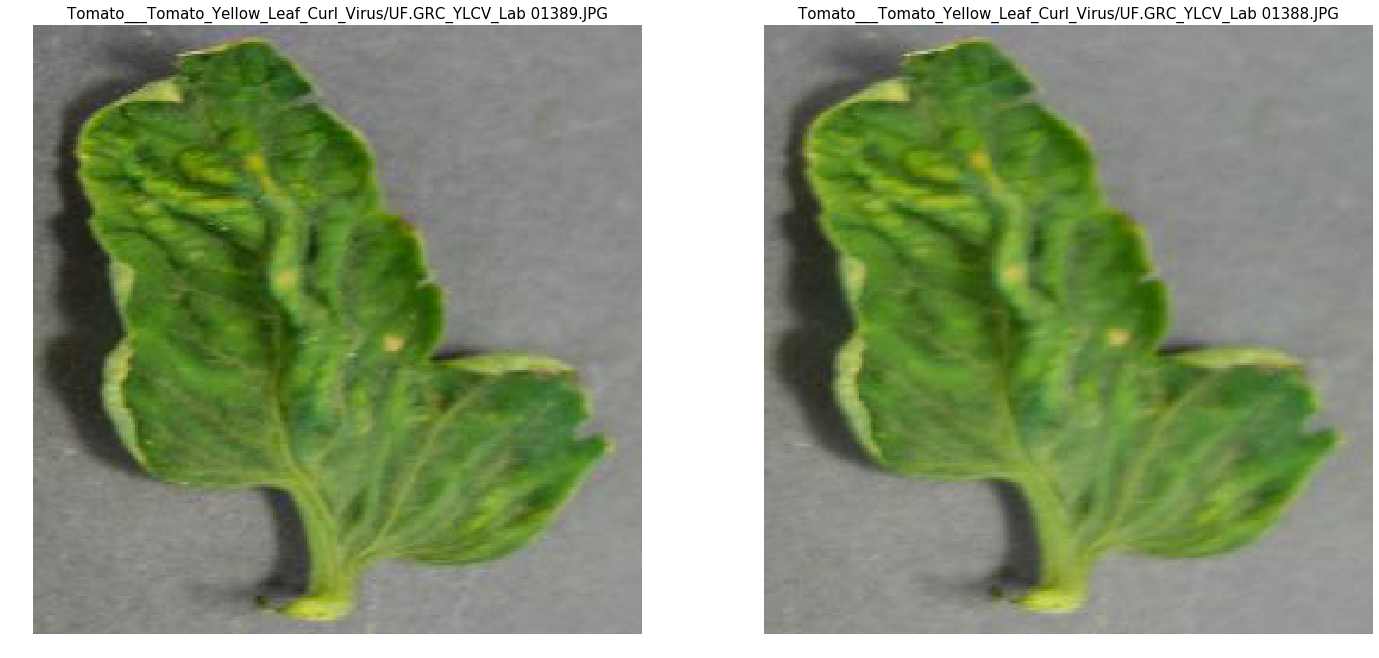

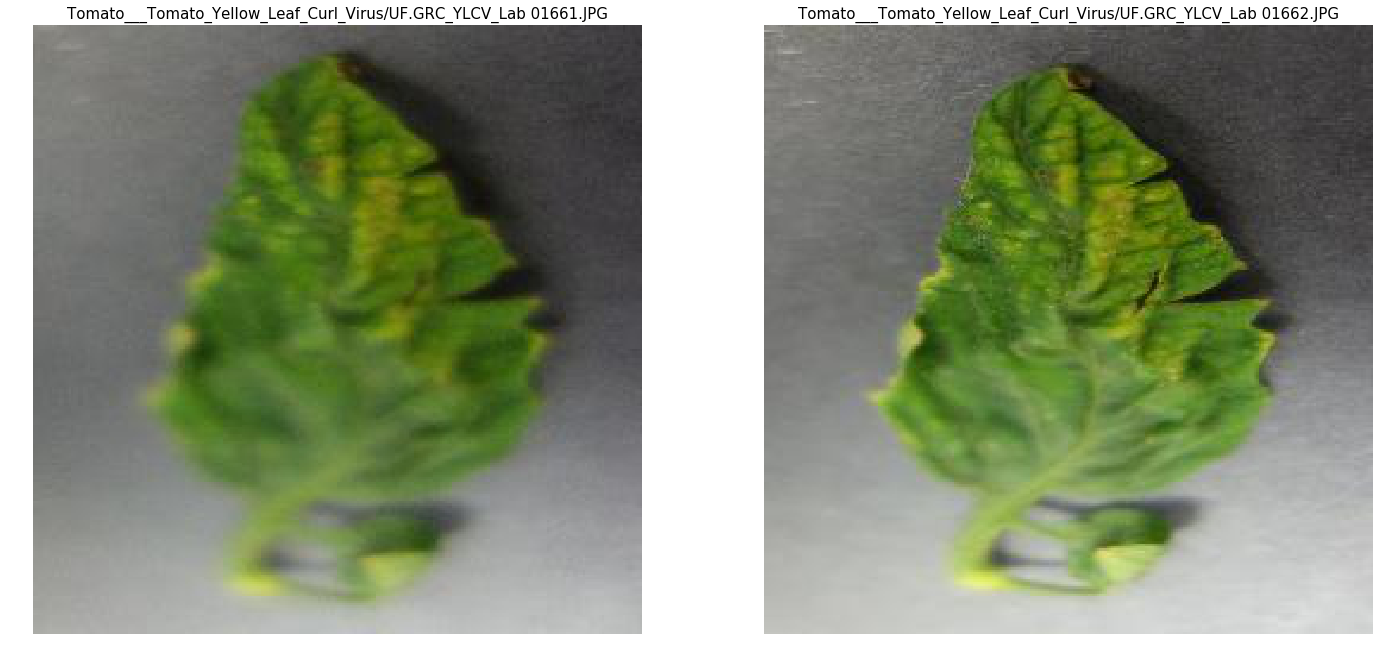

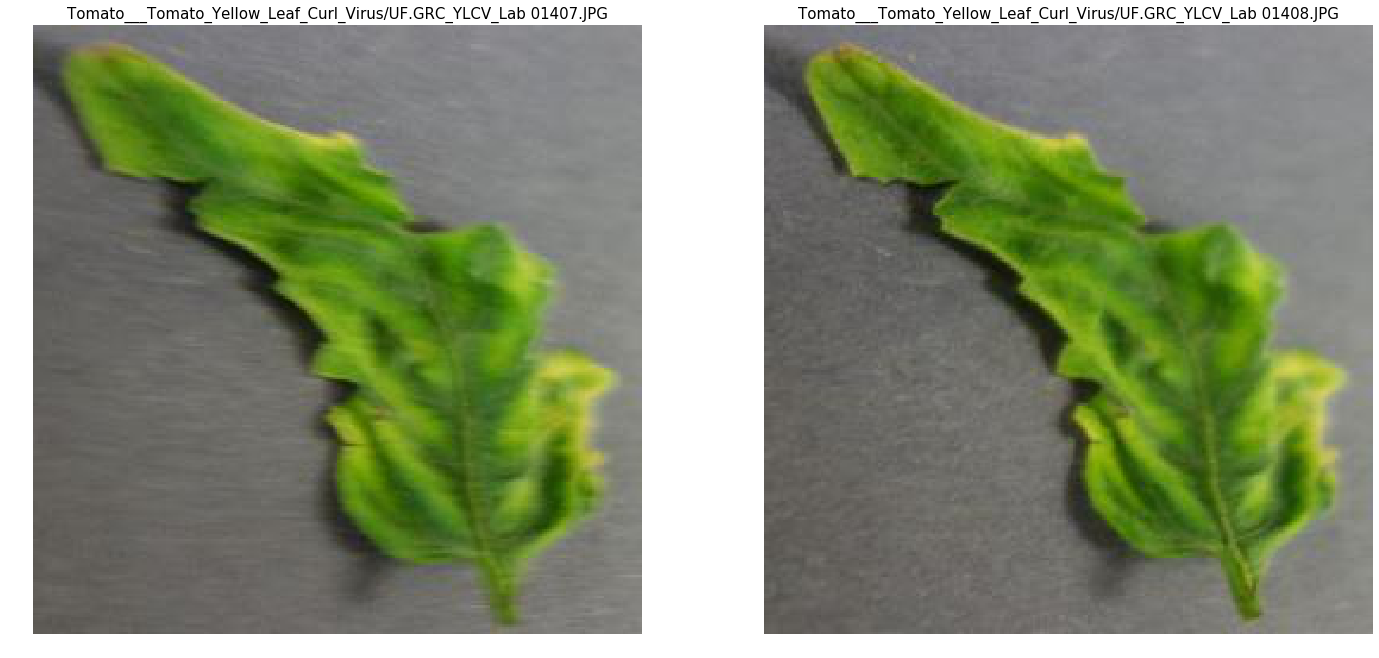

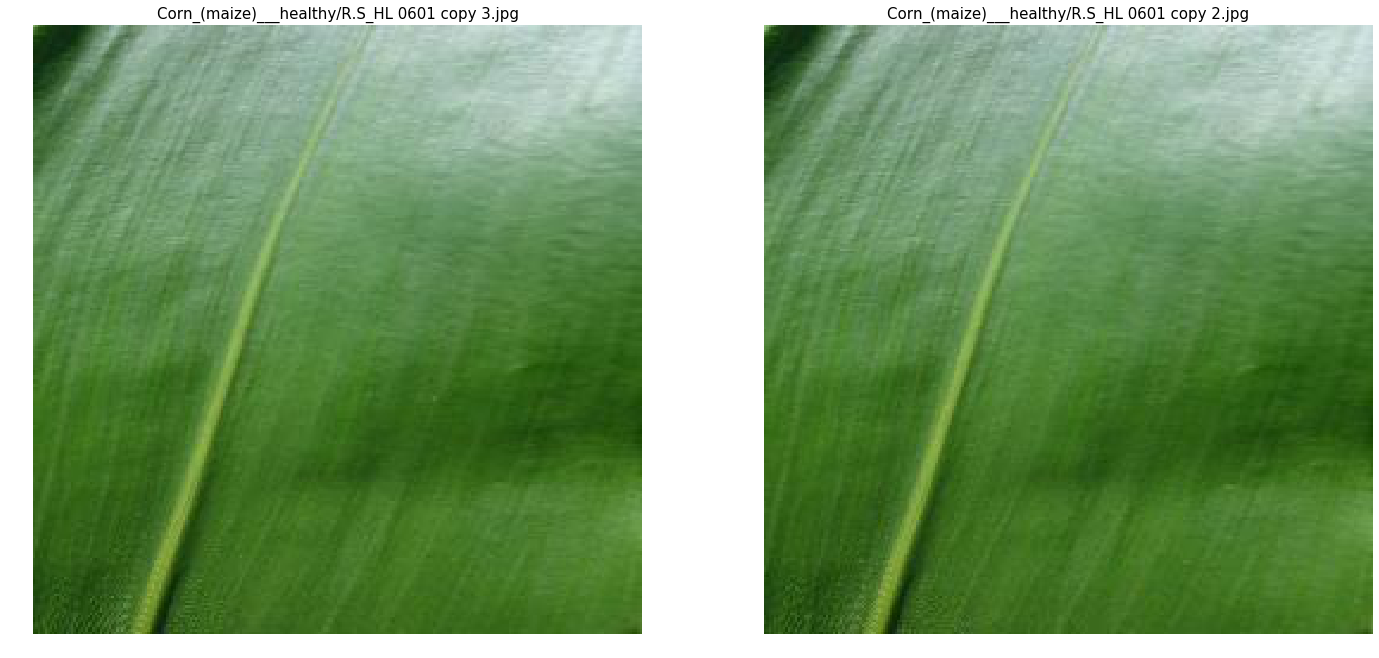

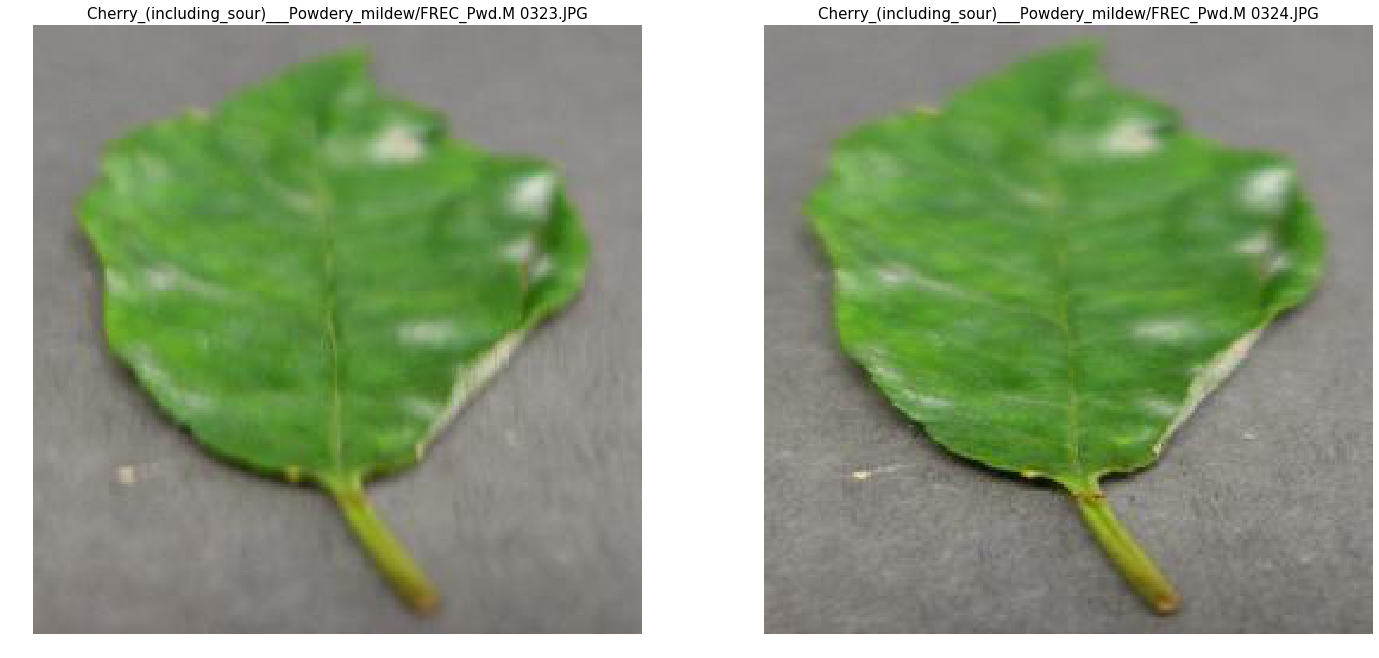

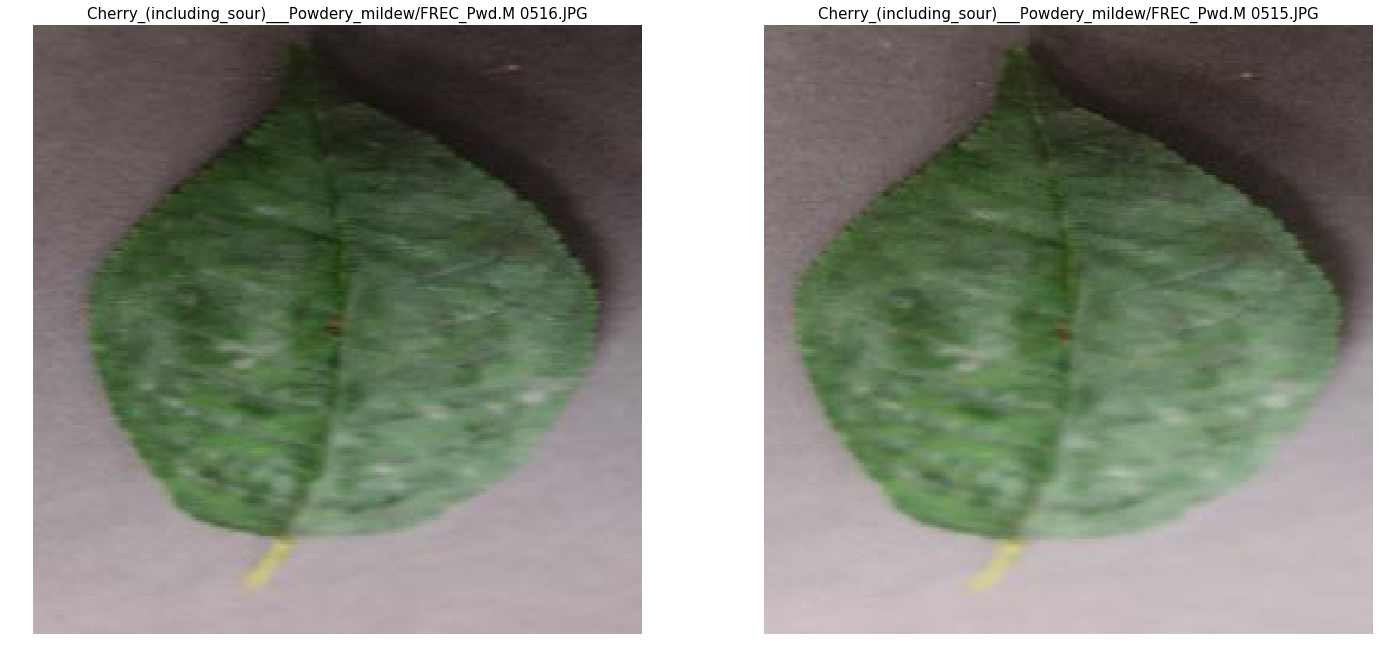

In [4]:
dataset.remove_duplicate_image = True
dataset.show_duplicate_image = True
print("The duplicate images to be ignored:")
print(dataset.duplicate_be_ignored)

In [5]:
dataset.remove_duplicate_image = True
print("Label      Category      Image number", end=' ')
dataset_statistics, image_relative_path_list = dataset.get_dataset_statistics()
image_number = [dataset_statistics[i][1] for i in range(len(dataset_statistics))]
print("(total_image_number =", str(sum(image_number)), 
      ", max_image_number =", str(max(image_number)), 
      ", min_image_number =", str(min(image_number)), ")")
for pos, categoryInfo in enumerate(dataset_statistics):
    print(pos, categoryInfo)

Label      Category      Image number (total_image_number = 54272 , max_image_number = 5501 , min_image_number = 152 )
0 ('Apple___Apple_scab', 630)
1 ('Apple___Black_rot', 621)
2 ('Apple___Cedar_apple_rust', 275)
3 ('Apple___healthy', 1638)
4 ('Blueberry___healthy', 1502)
5 ('Cherry_(including_sour)___Powdery_mildew', 1050)
6 ('Cherry_(including_sour)___healthy', 854)
7 ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 513)
8 ('Corn_(maize)___Common_rust_', 1192)
9 ('Corn_(maize)___Northern_Leaf_Blight', 985)
10 ('Corn_(maize)___healthy', 1161)
11 ('Grape___Black_rot', 1180)
12 ('Grape___Esca_(Black_Measles)', 1383)
13 ('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 1076)
14 ('Grape___healthy', 423)
15 ('Orange___Haunglongbing_(Citrus_greening)', 5501)
16 ('Peach___Bacterial_spot', 2297)
17 ('Peach___healthy', 360)
18 ('Pepper,_bell___Bacterial_spot', 997)
19 ('Pepper,_bell___healthy', 1478)
20 ('Potato___Early_blight', 1000)
21 ('Potato___Late_blight', 1000)
22 ('Potato___healthy

Species: number of diseases
defaultdict(<class 'int'>, {'Apple': 4, 'Blueberry': 1, 'Cherry': 2, 'Corn': 4, 'Grape': 4, 'Orange': 1, 'Peach': 2, 'Pepper,': 2, 'Potato': 3, 'Raspberry': 1, 'Soybean': 1, 'Squash': 1, 'Strawberry': 2, 'Tomato': 10})


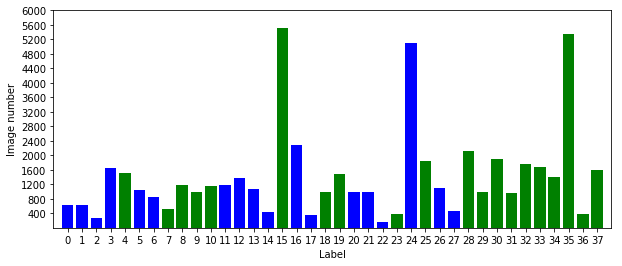

In [6]:
label_for_plot_list = [-1]
label_for_plot_list.extend([i for i in range(len(dataset_statistics))])
image_num_for_plot_list = [0]
image_num_for_plot_list.extend(image_number)
category_species_list = [dataset_statistics[i][0].split('_')[0] for i in range(len(dataset_statistics))]

def get_species_frequencies(category_species_list):
    frequencies = defaultdict(int)
    for item in category_species_list:
        frequencies[item] += 1
    return frequencies

species_frequencies = get_species_frequencies(category_species_list)
frequencies = [species_frequencies[key] for key in species_frequencies]
print("Species: number of diseases")
print(species_frequencies)
color_choice = [''] * len(frequencies)
for i in range(len(frequencies)):
    if (i%2) == 0:
        color_choice[i] = 'blue'
    else:
        color_choice[i] = 'green'
color_for_plot_list = ['white']
for index in range(len(frequencies)):
    color_for_plot_list.extend([color_choice[index]] * frequencies[index])
    
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-1, len(image_num_for_plot_list)-1)
ax.set_ylim(0, max(image_num_for_plot_list)+500)
my_x_ticks = label_for_plot_list[1:]
my_y_ticks = np.arange(400, 6400, 400)
ax.set_xticks(my_x_ticks)
ax.set_yticks(my_y_ticks)
ax.set_xlabel("Label")
ax.set_ylabel("Image number")
ax.bar(label_for_plot_list, image_num_for_plot_list, align='center', color=color_for_plot_list)
plt.show()

In [7]:
GROUP_EXISTS = True   # set GROUP_EXISTS to True or False
OVER_SAMPLING = False  # set OVER_SAMPLING to True or False

if GROUP_EXISTS:
    if isfile(str(pathlib.Path.cwd()) + "/" + "temp/leaf-map-1to1.json"):
        with open(str(pathlib.Path.cwd()) + "/" + "temp/leaf-map-1to1.json", "r") as f:
            leaf_map_1to1 = json.loads(f.read())
    else:
        MAP = {}
        for csv_file in glob.glob(str(pathlib.Path.cwd()) + "/" + "raw_datasets/csvs/plantVillage_map/*.csv"):
            csv_content = open(csv_file, "r")
            reader = csv.DictReader(csv_content)
            folder_name = csv_file.split("/")[-1].split(".")[0]
            for row in reader:
                file_name = row['File Name'].strip()
                leaf_id = row['Leaf #'].strip()
                value = folder_name + ":::" + leaf_id   # Raspberry___healthy:::1
                key = folder_name + "/" + file_name   # Raspberry___healthy/Mary_HL 9340.JPG
                MAP[key] = value

        with open(str(pathlib.Path.cwd()) + "/" + "temp/leaf-map-1to1.json", "w") as f:
            f.write(json.dumps(MAP))
        leaf_map_1to1 = MAP
    print("The leaf-map-1to1.json file is under " + str(pathlib.Path.cwd()) + "/" + "temp.")
else:
    leaf_map_1to1 = {}
    print("There are no files recording image groups.")

The leaf-map-1to1.json file is under /home/gxty/pycharmProjects/plant_disease_detection_project/temp.


In [8]:
category_list = [dataset_statistics[i][0] for i in range(len(dataset_statistics))]   # str
image_label_list = [category_list.index(item.split('/')[0]) for item in image_relative_path_list]   # int
group_id_list = ['None'] * len(image_relative_path_list)   # str

if GROUP_EXISTS:
    id_unmapping = max(image_number)
    for index, item in enumerate(image_relative_path_list):
        if item in leaf_map_1to1.keys():
            group_id_list[index] = leaf_map_1to1[item]
        else:
            group_id_list[index] = item.split("/")[0] +  ":::" + str(id_unmapping)   # Raspberry___healthy:::54272
            id_unmapping += 1

_, group_id_indices = np.unique(np.array(group_id_list), return_inverse=True)            
frame = {'relative_path': image_relative_path_list,   # str
         'label': image_label_list,   # int
         'group_id': group_id_indices}   # int
data = DataFrame(frame)
data.sort_values(by='label', inplace=True)
data.reset_index(drop=True, inplace=True)
pd.set_option('display.max_columns', None)
print(data[:5])

# L. Shen, et al. Relay Backpropagation for Effective Learning of Deep Convolutional Neural Networks. ECCV, 2016.
# Zhong Q.Y. et al. Towards Good Practices for Recognition & Detection. Hikvision Research Institute. 2016.
def get_oversampling_data(data, image_number, over_sampling=OVER_SAMPLING):
    """return a Pandas DataFrame with the columns 'relative_path', 'label' and 'group_id'
    """
    if over_sampling:
        temp_relative_path_list = []
        temp_image_label_list = []
        temp_group_id_indices_list = []
        start = 0
        end = 0
        for i in range(len(image_number)):
            temp = [k % image_number[i] for k in range(max(image_number))]
            random.shuffle(temp)
            end += image_number[i]
            temp_df = data[start:end]
            start = end
            for id in temp:
                temp_relative_path_list.append(temp_df.iat[id, 0])
                temp_image_label_list.append(temp_df.iat[id, 1])
                temp_group_id_indices_list.append(temp_df.iat[id, 2])
        data_oversampling = DataFrame({'relative_path': temp_relative_path_list, 
                                       'label': temp_image_label_list, 
                                       'group_id': temp_group_id_indices_list})
    else:
        data_oversampling = data
    return data_oversampling

def get_data_dict(image_number, df=data):
    """return a dictionary {'label_i': [([imag1, imag2, ...], group_id), ...]
                            'label_j': ...}
    """
    data_dict = {}
    for index in range(len(image_number)):
        temp_df = df.loc[df['label'] == index]
        temp_unique_groups = np.unique(np.array(temp_df['group_id']))
        temp_list = [(temp_df['relative_path'][temp_df['group_id'] == item].values.tolist(), item) 
                     for item in temp_unique_groups]
        data_dict[str(index)] = temp_list
    return data_dict

data = get_oversampling_data(data, image_number, over_sampling=OVER_SAMPLING)
data_dict = get_data_dict(image_number, df=data)
print(data_dict['22'][:3])

                           relative_path  label  group_id
0  Apple___Apple_scab/FREC_Scab 3041.JPG      0        26
1  Apple___Apple_scab/FREC_Scab 3014.JPG      0        21
2  Apple___Apple_scab/FREC_Scab 3387.JPG      0        94
3  Apple___Apple_scab/FREC_Scab 3110.JPG      0        41
4  Apple___Apple_scab/FREC_Scab 3391.JPG      0        95
[(['Potato___healthy/RS_HL 1740.JPG', 'Potato___healthy/RS_HL 1735.JPG', 'Potato___healthy/RS_HL 1738.JPG', 'Potato___healthy/RS_HL 1736.JPG'], 8243), (['Potato___healthy/RS_HL 1813.JPG', 'Potato___healthy/RS_HL 1814.JPG', 'Potato___healthy/RS_HL 1816.JPG', 'Potato___healthy/RS_HL 1817.JPG'], 8244), (['Potato___healthy/RS_HL 1824.JPG', 'Potato___healthy/RS_HL 1819.JPG', 'Potato___healthy/RS_HL 1825.JPG', 'Potato___healthy/RS_HL 1826.JPG'], 8245)]


In [9]:
def get_train_test_val_split(data_dict, image_number, train_prob=0.7, test_prob=0.2, 
                             group_exists=GROUP_EXISTS, over_sampling=OVER_SAMPLING):
    train_dict = {}
    test_dict = {}
    val_dict = {}
    
    for label in data_dict.keys():
        temp_image_group_list = data_dict[label]
        random.shuffle(temp_image_group_list)
        if not OVER_SAMPLING:
            temp_image_number = image_number[int(label)]
        else:
            temp_image_number = max(image_number)
        temp_train_num = 0
        temp_test_num = 0
        train_list = []
        test_list = []
        val_list = []
        
        if group_exists:
            for item in temp_image_group_list:
                random.shuffle(item[0])
                if temp_train_num < round(temp_image_number * train_prob):
                    temp_train_num += len(item[0])
                    train_list.append(item)
                elif temp_train_num >= round(temp_image_number * train_prob):
                    if temp_test_num < round(temp_image_number * test_prob):
                        temp_test_num += len(item[0])
                        test_list.append(item)
                    else:
                        val_list.append(item)
        else:
            temp_image_list = temp_image_group_list[0][0]
            random.shuffle(temp_image_list)
            train_list.append((temp_image_list[0:round(temp_image_number * train_prob)],temp_image_group_list[0][1]))
            test_list.append((temp_image_list[round(temp_image_number * train_prob):round(temp_image_number * (train_prob + test_prob))],
                              temp_image_group_list[0][1]))
            val_list.append((temp_image_list[round(temp_image_number * (train_prob + test_prob)):], temp_image_group_list[0][1]))
                        
        train_dict[label] = train_list
        test_dict[label] = test_list
        val_dict[label] = val_list
    return (train_dict, test_dict, val_dict)

                
train_dict, test_dict, val_dict = get_train_test_val_split(data_dict, image_number, 
                                                           train_prob=0.7, test_prob=0.2, 
                                                           group_exists=GROUP_EXISTS, over_sampling=OVER_SAMPLING)

# for group_exists=True
# print(str(len(train_dict['4'])))
# print(str(len(test_dict['4'])))
# print(str(len(val_dict['4'])))

# for group_exists=False
# print(str(len(train_dict['22'][0][0])))
# print(str(len(test_dict['22'][0][0])))
# print(str(len(val_dict['22'][0][0])))

In [10]:
def get_dataframe(data_dict=data_dict):
    """return a DataFrame with three columns(relative_path   label   group_id).
    """
    temp_path_label_groupid_list = []
    for label in data_dict.keys():
        temp_image_group_list = data_dict[label]
        for item in temp_image_group_list:
            for img in item[0]:
                temp_path_label_groupid_list.append((img, int(label), item[1]))
    random.shuffle(temp_path_label_groupid_list)
    
    temp_relative_path_list = []
    temp_image_label_list = []
    temp_group_id_indices_list = []
    
    temp_relative_path_list = [item[0] for item in temp_path_label_groupid_list]
    temp_image_label_list = [item[1] for item in temp_path_label_groupid_list]
    temp_group_id_indices_list = [item[2] for item in temp_path_label_groupid_list]
    
    df = DataFrame({'relative_path': temp_relative_path_list, 
                    'label': temp_image_label_list, 
                    'group_id': temp_group_id_indices_list})
    
    return df

df_train = get_dataframe(data_dict=train_dict)
df_test = get_dataframe(data_dict=test_dict)
df_val = get_dataframe(data_dict=val_dict)
print("train size proportion is {:.2f}.".format((len(df_train)+0.0)/(len(df_train) + len(df_test) + len(df_val))))
print("test size proportion is {:.2f}.".format((len(df_test)+0.0)/(len(df_train) + len(df_test) + len(df_val))))
print("validation size proportion is {:.2f}.".format((len(df_val)+0.0)/(len(df_train) + len(df_test) + len(df_val))))

train size proportion is 0.70.
test size proportion is 0.20.
validation size proportion is 0.10.


In [11]:
def merge_train_val_in_one_df(df_train=df_train, df_val=df_val):
    merged_df = pd.concat([df_train, df_val], ignore_index=True)
    val_sign_list = ['False']*len(df_train) + ['True']*len(df_val)
    merged_df.insert(2,'is_valid',val_sign_list)
    return merged_df

merged_df = merge_train_val_in_one_df(df_train=df_train, df_val=df_val)

In [12]:
if GROUP_EXISTS and not OVER_SAMPLING:
    print("group_exists = True & over_sampling = False")
    merged_df.to_csv(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv", index=False)
    df_test.to_csv(str(pathlib.Path.cwd()) + "/temp/" + "test_group.csv", index=False)
elif GROUP_EXISTS and OVER_SAMPLING:
    print("group_exists = True & over_sampling = True")
    merged_df.to_csv(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group_oversampling.csv", index=False)
    df_test.to_csv(str(pathlib.Path.cwd()) + "/temp/" + "test_group_oversampling.csv", index=False)
elif not GROUP_EXISTS and not OVER_SAMPLING:
    print("group_exists = False & over_sampling = False")
    merged_df.to_csv(str(pathlib.Path.cwd()) + "/temp/" + "train_val.csv", index=False)
    df_test.to_csv(str(pathlib.Path.cwd()) + "/temp/" + "test.csv", index=False)
elif not GROUP_EXISTS and OVER_SAMPLING:
    print("group_exists = False & over_sampling = True")
    merged_df.to_csv(str(pathlib.Path.cwd()) + "/temp/" + "train_val_oversampling.csv", index=False)
    df_test.to_csv(str(pathlib.Path.cwd()) + "/temp/" + "test_oversampling.csv", index=False)

group_exists = True & over_sampling = False


In [13]:
def calculate_training_set_mean_std(input_csv, image_width, image_height, resize_mode=pil_image.ANTIALIAS):
    load_queue = queue.Queue()   # Creat an empty queue which will store the relative_path column of train_val*.csv.
    image_count = _fill_load_queue(input_csv, load_queue)   # The number of images to be calculated
    num_threads = 10
    summary_queue = queue.Queue()   # Creat an empty queue which will store (img_sum, img_square_sum, img_added) tuples.
    
    for _ in range(num_threads):
        p = threading.Thread(target=_load_thread,   #summary_queue.put((img_sum, img_square_sum, img_added))
                             args=(load_queue, summary_queue, image_width, image_height, resize_mode))
        p.daemon = True
        p.start()
    
    image_sum, image_square_sum = _get_sum_and_square_sum(image_count, summary_queue, num_threads)
    image_mean = image_sum/image_count
    image_std = np.sqrt(image_square_sum/(image_count-1) - (image_mean**2)*image_count/(image_count-1))
    print("Training set pixel value mean [R G B]: " + str(np.around(image_mean, decimals=2)))
    print("Training set pixel standard error [R G B]: " + str(np.around(image_std, decimals=2)))
    
def _fill_load_queue(input_csv, load_queue):
    total_imgs = 0
    original_data = pd.read_csv(input_csv)
    relative_path = original_data['relative_path']
    for pos in relative_path.index:
        total_imgs += 1
        load_queue.put(relative_path.loc[pos])
    return total_imgs
    
def _get_sum_and_square_sum(image_count, summary_queue, num_threads):
    wait_time = time.time()
    threads_done = 0
    images_loaded = 0
    image_sum = None
    image_square_sum = None
    
    while threads_done < num_threads or not summary_queue.empty():
        processed_something = False
        
        if not summary_queue.empty():
            result_sum, result_square_sum, result_added = summary_queue.get()
            images_loaded += result_added
            if result_added > 0 and result_sum is not None and result_square_sum is not None:
                if image_sum is None:
                    image_sum = result_sum
                else:
                    image_sum += result_sum
                if image_square_sum is None:
                    image_square_sum = result_square_sum
                else:
                    image_square_sum += result_square_sum
            threads_done += 1
            processed_something = True
            
        if not processed_something:
            time.sleep(0.2)
        
    if images_loaded == 0:
        raise Exception("No images loaded from input file")
    print("Debug:: %s images loaded" % images_loaded)
        
    return (image_sum, image_square_sum)
    
    
def _load_thread(load_queue, summary_queue, image_width, image_height, resize_mode):
    img_sum = np.zeros((1, 3), np.float64)
    img_square_sum = np.zeros((1, 3), np.float64)
    img_added = 0
    
    while not load_queue.empty():
        try:
            relative_path = load_queue.get(True, 0.05)
        except queue.Empty:
            continue
        try:
            path = str(dataset.absolute_dataset_path) + "/" + relative_path
            image = _load_image(path)
        except Exception as e:
            print("Warning:: [%s] %s: %s" % (path, type(e).__name__, e))
            continue
        image = image.resize((image_width, image_height), resize_mode)
        image_array = np.asarray(image, dtype=np.float64).transpose((2, 0, 1))
        temp_img_sum = image_array.sum(axis=(1,2))/(image_width*image_height*255)
        temp_img_square_sum = np.square(image_array).sum(axis=(1,2))/(image_width*image_height*(255**2))
        img_sum += temp_img_sum[np.newaxis, :]
        img_square_sum += temp_img_square_sum[np.newaxis, :]
        img_added += 1
        
    summary_queue.put((img_sum, img_square_sum, img_added))
    
def _load_image(path):
    image = None
    if pathlib.Path(path).exists():
        try:
            image = pil_image.open(path)
            image.load()   # Return values of pixels, and these values can be modified.
        except IOError as e:
            print('IOError: %s' % e.message)
    else:
            print('"%s" not found' % path)

    if image.mode in ['L', 'RGB']:   # 'L' - grayscale
        # No conversion necessary
        return image
    elif image.mode in ['1']:   # '1' - binary image
        # Easy conversion to L
        return image.convert('L')
    elif image.mode in ['LA']:   # the last channel refers to transparency, 0 for clear and 255 for opaque.
        # Deal with transparencies
        new = pil_image.new('L', image.size, 255)
        new.paste(image, mask=image.convert('RGBA'))
        return new
    elif image.mode in ['CMYK', 'YCbCr']:
        # Easy conversion to RGB
        return image.convert('RGB')
    elif image.mode in ['P', 'RGBA']:
        # Deal with transparencies
        new = pil_image.new('RGB', image.size, (255, 255, 255))
        new.paste(image, mask=image.convert('RGBA'))
        return new
    else:
        print('Image mode "%s" not supported' % image.mode)

In [14]:
input_csv = str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv"
image_width = 256
image_height = 256
calculate_training_set_mean_std(input_csv, image_width, image_height, resize_mode=pil_image.ANTIALIAS)

Debug:: 43353 images loaded
Training set pixel value mean [R G B]: [[0.47 0.49 0.41]]
Training set pixel standard error [R G B]: [[0.2  0.18 0.22]]


In [15]:
input_csv = str(pathlib.Path.cwd()) + "/temp/" + "train_val_group_oversampling.csv"
image_width = 256
image_height = 256
calculate_training_set_mean_std(input_csv, image_width, image_height, resize_mode=pil_image.ANTIALIAS)

Debug:: 166502 images loaded
Training set pixel value mean [R G B]: [[0.47 0.49 0.42]]
Training set pixel standard error [R G B]: [[0.2  0.18 0.22]]


In [16]:
input_csv = str(pathlib.Path.cwd()) + "/temp/" + "train_val.csv"
image_width = 256
image_height = 256
calculate_training_set_mean_std(input_csv, image_width, image_height, resize_mode=pil_image.ANTIALIAS)

Debug:: 43419 images loaded
Training set pixel value mean [R G B]: [[0.47 0.49 0.41]]
Training set pixel standard error [R G B]: [[0.2  0.18 0.22]]


In [17]:
input_csv = str(pathlib.Path.cwd()) + "/temp/" + "train_val_oversampling.csv"
image_width = 256
image_height = 256
calculate_training_set_mean_std(input_csv, image_width, image_height, resize_mode=pil_image.ANTIALIAS)

Debug:: 167238 images loaded
Training set pixel value mean [R G B]: [[0.47 0.5  0.42]]
Training set pixel standard error [R G B]: [[0.2  0.18 0.22]]
